In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [15]:
filename = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet'
val_filename = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet'
categorical_features = ['PULocationID', 'DOLocationID']
def read_process_dataframe(filename):
    df = pd.read_parquet(filename)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df['trip_duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['trip_duration'] = df['trip_duration'].apply(lambda time_delta: time_delta.total_seconds()/60)
    df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]
    df[categorical_features] = df[categorical_features].astype('str')
    return df

In [16]:
df_train = read_process_dataframe(filename)
df_val = read_process_dataframe(val_filename)
categorical_features = ['PU_DU']
df_train['PU_DU'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DU'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration,PU_DU
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.80,...,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000,236_239
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.30,...,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667,65_170
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.80,...,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333,74_262
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.20,...,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667,74_116
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.60,...,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333,74_243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56546,2,2024-01-31 20:46:00,2024-01-31 20:55:00,None,NaN,33,25,NaN,0.00,11.58,...,3.14,0.0,NaN,1.0,15.72,NaN,NaN,NaN,9.000000,33_25
56547,2,2024-01-31 21:06:00,2024-01-31 21:11:00,None,NaN,72,72,NaN,0.49,11.58,...,0.00,0.0,NaN,1.0,12.58,NaN,NaN,NaN,5.000000,72_72
56548,2,2024-01-31 21:36:00,2024-01-31 21:40:00,None,NaN,72,72,NaN,0.52,11.58,...,2.52,0.0,NaN,1.0,15.10,NaN,NaN,NaN,4.000000,72_72
56549,2,2024-01-31 22:45:00,2024-01-31 22:51:00,None,NaN,41,42,NaN,1.17,14.22,...,0.00,0.0,NaN,1.0,15.22,NaN,NaN,NaN,6.000000,41_42


In [17]:
dv = DictVectorizer()
numerical_features = ['trip_distance']

train_dicts = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
y_train = df_train.trip_duration.values
y_val = df_val.trip_duration.values

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_pred, y_val, squared=False)

6.178273335108125

In [28]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [29]:
lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_pred, y_val, squared=False)

6.566915113827622

In [30]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_pred, y_val, squared=False)

6.65700517898182

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


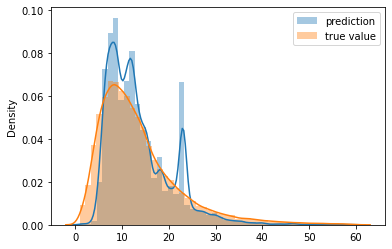

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='true value')
plt.legend()